In [23]:
%load_ext autoreload
%autoreload 2
from pybaseball import statcast, pitching_stats
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04')]#,      # 2015 data
#                     ('2016-04-03', '2016-10-02'),       # 2016 data
#                     ('2017-04-02', '2017-10-01'),       # 2017 data
#                     ('2018-03-29', '2018-10-01')]       # 2018 data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### build the dataframe

In [3]:
raw_data = statcast(start_dt=train_data_dates[0][0], end_dt=train_data_dates[0][1], verbose=0)
print(raw_data.shape)
raw_data.head()

This is a large query, it may take a moment to complete
(702302, 90)


,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,245,SI,2015-10-04,97.2,-1.3222,6.4094,Jeurys Familia,150029.0,544727.0,field_out,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN
1,253,SI,2015-10-04,97.5,-1.2561,6.4222,Jeurys Familia,150029.0,544727.0,NaN,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Standard
2,263,SI,2015-10-04,98.4,-1.2591,6.3362,Jeurys Familia,547180.0,544727.0,double,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Strategic
3,269,SI,2015-10-04,97.7,-1.2283,6.2723,Jeurys Familia,607208.0,544727.0,strikeout,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Standard
4,280,SI,2015-10-04,98.2,-1.2233,6.2351,Jeurys Familia,607208.0,544727.0,NaN,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Standard,Standard


### select the outcome and features

In [4]:
outcome = ['pitch_type']

id_columns = ['game_pk', 'pitcher', 'batter']

situation_features = ['stand', 'p_throws', 'inning', 'balls', 'strikes', 
                      'on_1b', 'on_2b', 'on_3b', 'outs_when_up', 'pitch_number', 
                      'fld_score', 'bat_score']

prev_pitch_features = ['type', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_speed', 'release_spin_rate']

data = raw_data[outcome + id_columns + situation_features + prev_pitch_features]

print(data.shape)
data.head()

(702302, 23)


,pitch_type,game_pk,pitcher,batter,stand,p_throws,inning,balls,strikes,on_1b,...,pitch_number,fld_score,bat_score,type,pfx_x,pfx_z,plate_x,plate_z,release_speed,release_spin_rate
0,SI,416079.0,544727.0,150029.0,R,R,9.0,0.0,1.0,NaN,...,2.0,1.0,0.0,X,-1.118083,0.455133,-0.707,2.022,97.2,2018.0
1,SI,416079.0,544727.0,150029.0,R,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,S,-1.108342,0.711700,0.442,3.496,97.5,2093.0
2,SI,416079.0,544727.0,547180.0,L,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,X,-1.523058,0.523933,-0.353,2.446,98.4,1960.0
3,SI,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,7.0,1.0,0.0,S,-1.285083,0.618533,-0.054,1.273,97.7,2099.0
4,SI,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,6.0,1.0,0.0,S,-0.997008,0.803433,-0.406,1.560,98.2,2155.0


### clean up and feature engineering

In [5]:
# drop all columns with no pitch type categorization
data = data[pd.notnull(data['pitch_type'])]
print(data.shape)
data.head()

(701690, 23)


,pitch_type,game_pk,pitcher,batter,stand,p_throws,inning,balls,strikes,on_1b,...,pitch_number,fld_score,bat_score,type,pfx_x,pfx_z,plate_x,plate_z,release_speed,release_spin_rate
0,SI,416079.0,544727.0,150029.0,R,R,9.0,0.0,1.0,NaN,...,2.0,1.0,0.0,X,-1.118083,0.455133,-0.707,2.022,97.2,2018.0
1,SI,416079.0,544727.0,150029.0,R,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,S,-1.108342,0.711700,0.442,3.496,97.5,2093.0
2,SI,416079.0,544727.0,547180.0,L,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,X,-1.523058,0.523933,-0.353,2.446,98.4,1960.0
3,SI,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,7.0,1.0,0.0,S,-1.285083,0.618533,-0.054,1.273,97.7,2099.0
4,SI,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,6.0,1.0,0.0,S,-0.997008,0.803433,-0.406,1.560,98.2,2155.0


In [6]:
# categorize pitch types as "Fastball" (1) or "Off-speed" (0)
fastball_pitches = ['FA', 'FF', 'FT', 'FC', 'FS', 'SI', 'SF']
def map_fastballs(x):
    if x in fastball_pitches:
        return 1
    else:
        return 0
data['pitch_type'] = data['pitch_type'].apply(map_fastballs)

data.head()

,pitch_type,game_pk,pitcher,batter,stand,p_throws,inning,balls,strikes,on_1b,...,pitch_number,fld_score,bat_score,type,pfx_x,pfx_z,plate_x,plate_z,release_speed,release_spin_rate
0,1,416079.0,544727.0,150029.0,R,R,9.0,0.0,1.0,NaN,...,2.0,1.0,0.0,X,-1.118083,0.455133,-0.707,2.022,97.2,2018.0
1,1,416079.0,544727.0,150029.0,R,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,S,-1.108342,0.711700,0.442,3.496,97.5,2093.0
2,1,416079.0,544727.0,547180.0,L,R,9.0,0.0,0.0,NaN,...,1.0,1.0,0.0,X,-1.523058,0.523933,-0.353,2.446,98.4,1960.0
3,1,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,7.0,1.0,0.0,S,-1.285083,0.618533,-0.054,1.273,97.7,2099.0
4,1,416079.0,544727.0,607208.0,R,R,9.0,3.0,2.0,NaN,...,6.0,1.0,0.0,S,-0.997008,0.803433,-0.406,1.560,98.2,2155.0


In [7]:
# make sure ID columns are int's
for col in id_columns:
    data[col] = data[col].astype(int)
    
# convert innings, balls and strikes to ints
for col in ['inning', 'balls', 'strikes', 'outs_when_up', 'pitch_number']:
    data[col] = data[col].astype(int)
    
# if inning > 9, just replace with "9"
def cap_extra_innings(x):
    if x > 9:
        return 9
    else:
        return x
data['inning'] = data['inning'].apply(cap_extra_innings)
    
# make a new id based on game id + pitcher id that we can use for groupby's
data['game_pitcher_id'] = data['game_pk'].astype(str) + '_' + data['pitcher'].astype(str)

# convert on_1b/on_2b/on_3b to boolean 
data['on_1b'] = data['on_1b'].apply(lambda x: not np.isnan(x))
data['on_2b'] = data['on_2b'].apply(lambda x: not np.isnan(x))
data['on_3b'] = data['on_3b'].apply(lambda x: not np.isnan(x))

# handedness: does the batter hit from the same side that the pitcher is pitching from
data['pitch_bat_same_side'] = data['p_throws'] == data['stand'] 
data.drop(['p_throws', 'stand'], axis=1, inplace=True)

# score differential
data['score_diff'] = data['fld_score'] - data['bat_score']
data.drop(['fld_score', 'bat_score'], axis=1, inplace=True)

data.head()

,pitch_type,game_pk,pitcher,batter,inning,balls,strikes,on_1b,on_2b,on_3b,...,type,pfx_x,pfx_z,plate_x,plate_z,release_speed,release_spin_rate,game_pitcher_id,pitch_bat_same_side,score_diff
0,1,416079,544727,150029,9,0,1,False,True,False,...,X,-1.118083,0.455133,-0.707,2.022,97.2,2018.0,416079_544727,True,1.0
1,1,416079,544727,150029,9,0,0,False,True,False,...,S,-1.108342,0.711700,0.442,3.496,97.5,2093.0,416079_544727,True,1.0
2,1,416079,544727,547180,9,0,0,False,False,False,...,X,-1.523058,0.523933,-0.353,2.446,98.4,1960.0,416079_544727,False,1.0
3,1,416079,544727,607208,9,3,2,False,False,False,...,S,-1.285083,0.618533,-0.054,1.273,97.7,2099.0,416079_544727,True,1.0
4,1,416079,544727,607208,9,3,2,False,False,False,...,S,-0.997008,0.803433,-0.406,1.560,98.2,2155.0,416079_544727,True,1.0


In [8]:
# groupby on game_pitcher_id and tabulate previous pitch data
for col in prev_pitch_features + outcome:
    data['prev_'+col] = data.groupby('game_pitcher_id')[col].apply(lambda x: x.shift(1))
data.drop(prev_pitch_features, axis=1, inplace=True)

# fill the missing prev_pitch_type with an Unknown token
data['prev_pitch_type'].fillna('UN', inplace=True)
data['prev_type'].fillna('UN', inplace=True)

print(data.shape)
data.head()

(701690, 23)


,pitch_type,game_pk,pitcher,batter,inning,balls,strikes,on_1b,on_2b,on_3b,...,pitch_bat_same_side,score_diff,prev_type,prev_pfx_x,prev_pfx_z,prev_plate_x,prev_plate_z,prev_release_speed,prev_release_spin_rate,prev_pitch_type
0,1,416079,544727,150029,9,0,1,False,True,False,...,True,1.0,UN,NaN,NaN,NaN,NaN,NaN,NaN,UN
1,1,416079,544727,150029,9,0,0,False,True,False,...,True,1.0,X,-1.118083,0.455133,-0.707,2.022,97.2,2018.0,1
2,1,416079,544727,547180,9,0,0,False,False,False,...,False,1.0,S,-1.108342,0.711700,0.442,3.496,97.5,2093.0,1
3,1,416079,544727,607208,9,3,2,False,False,False,...,True,1.0,X,-1.523058,0.523933,-0.353,2.446,98.4,1960.0,1
4,1,416079,544727,607208,9,3,2,False,False,False,...,True,1.0,S,-1.285083,0.618533,-0.054,1.273,97.7,2099.0,1


In [9]:
# fill missing prev_pitch_velocity with pitcher's mean velocity
for col in prev_pitch_features:
    if col != 'type':
        data["prev_"+col] = data.groupby("game_pitcher_id")["prev_"+col].transform(lambda x: x.fillna(x.mean()))

print(data.shape)
data.head()

(701690, 23)


,pitch_type,game_pk,pitcher,batter,inning,balls,strikes,on_1b,on_2b,on_3b,...,pitch_bat_same_side,score_diff,prev_type,prev_pfx_x,prev_pfx_z,prev_plate_x,prev_plate_z,prev_release_speed,prev_release_spin_rate,prev_pitch_type
0,1,416079,544727,150029,9,0,1,False,True,False,...,True,1.0,UN,-1.166096,0.672693,-0.275429,2.100786,96.571429,1971.714286,UN
1,1,416079,544727,150029,9,0,0,False,True,False,...,True,1.0,X,-1.118083,0.455133,-0.707000,2.022000,97.200000,2018.000000,1
2,1,416079,544727,547180,9,0,0,False,False,False,...,False,1.0,S,-1.108342,0.711700,0.442000,3.496000,97.500000,2093.000000,1
3,1,416079,544727,607208,9,3,2,False,False,False,...,True,1.0,X,-1.523058,0.523933,-0.353000,2.446000,98.400000,1960.000000,1
4,1,416079,544727,607208,9,3,2,False,False,False,...,True,1.0,S,-1.285083,0.618533,-0.054000,1.273000,97.700000,2099.000000,1


In [10]:
for col in data.columns.tolist():
    print(col, data[col].tolist()[:10])

pitch_type [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
game_pk [416079, 416079, 416079, 416079, 416079, 416079, 416079, 416079, 416079, 416079]
pitcher [544727, 544727, 544727, 544727, 544727, 544727, 544727, 544727, 544727, 544727]
batter [150029, 150029, 547180, 607208, 607208, 607208, 607208, 607208, 607208, 607208]
inning [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
balls [0, 0, 0, 3, 3, 2, 2, 1, 1, 0]
strikes [1, 0, 0, 2, 2, 2, 1, 1, 0, 0]
on_1b [False, False, False, False, False, False, False, False, False, False]
on_2b [True, True, False, False, False, False, False, False, False, False]
on_3b [False, False, False, False, False, False, False, False, False, False]
outs_when_up [2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
pitch_number [2, 1, 1, 7, 6, 5, 4, 3, 2, 1]
game_pitcher_id ['416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727']
pitch_bat_same_side [True, True, False, True, True, True, True, True, True

### pitch probabilities for given state of at-bat

In [11]:
cols_to_groupby = ['pitcher', 'outs_when_up', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b']

data_fb_prob = pd.DataFrame(data.groupby(cols_to_groupby)['pitch_type'].mean())

data_fb_prob.rename(columns={'pitch_type': 'fb_prob'}, inplace=True)

data_fb_prob.reset_index(inplace=True, drop=False)

data = pd.merge(data, data_fb_prob, how='left', on=cols_to_groupby)

print(data.shape)
data.head()

(701690, 24)


,pitch_type,game_pk,pitcher,batter,inning,balls,strikes,on_1b,on_2b,on_3b,...,score_diff,prev_type,prev_pfx_x,prev_pfx_z,prev_plate_x,prev_plate_z,prev_release_speed,prev_release_spin_rate,prev_pitch_type,fb_prob
0,1,416079,544727,150029,9,0,1,False,True,False,...,1.0,UN,-1.166096,0.672693,-0.275429,2.100786,96.571429,1971.714286,UN,0.857143
1,1,416079,544727,150029,9,0,0,False,True,False,...,1.0,X,-1.118083,0.455133,-0.707000,2.022000,97.200000,2018.000000,1,0.750000
2,1,416079,544727,547180,9,0,0,False,False,False,...,1.0,S,-1.108342,0.711700,0.442000,3.496000,97.500000,2093.000000,1,0.804348
3,1,416079,544727,607208,9,3,2,False,False,False,...,1.0,X,-1.523058,0.523933,-0.353000,2.446000,98.400000,1960.000000,1,1.000000
4,1,416079,544727,607208,9,3,2,False,False,False,...,1.0,S,-1.285083,0.618533,-0.054000,1.273000,97.700000,2099.000000,1,1.000000


In [12]:
# drop any remaining NA's
data.dropna(inplace=True)

In [13]:
for col in data.columns.tolist():
    print(col, data[col].tolist()[:5])

pitch_type [1, 1, 1, 1, 1]
game_pk [416079, 416079, 416079, 416079, 416079]
pitcher [544727, 544727, 544727, 544727, 544727]
batter [150029, 150029, 547180, 607208, 607208]
inning [9, 9, 9, 9, 9]
balls [0, 0, 0, 3, 3]
strikes [1, 0, 0, 2, 2]
on_1b [False, False, False, False, False]
on_2b [True, True, False, False, False]
on_3b [False, False, False, False, False]
outs_when_up [2, 2, 2, 1, 1]
pitch_number [2, 1, 1, 7, 6]
game_pitcher_id ['416079_544727', '416079_544727', '416079_544727', '416079_544727', '416079_544727']
pitch_bat_same_side [True, True, False, True, True]
score_diff [1.0, 1.0, 1.0, 1.0, 1.0]
prev_type ['UN', 'X', 'S', 'X', 'S']
prev_pfx_x [-1.1660958333333333, -1.118083333333333, -1.1083416666666663, -1.5230583333333332, -1.2850833333333331]
prev_pfx_z [0.672692857142857, 0.4551333333333333, 0.7117, 0.5239333333333333, 0.6185333333333332]
prev_plate_x [-0.2754285714285714, -0.707, 0.442, -0.353, -0.054]
prev_plate_z [2.1007857142857143, 2.022, 3.496, 2.446, 1.273]
prev_

In [18]:
cols_to_encode = ['inning', 'balls', 'strikes', 'outs_when_up', 'prev_type', 'prev_pitch_type']

data = pd.get_dummies(data, prefix=cols_to_encode, columns=cols_to_encode)

data.head()

,pitch_type,game_pk,pitcher,batter,on_1b,on_2b,on_3b,pitch_number,game_pitcher_id,pitch_bat_same_side,...,outs_when_up_0,outs_when_up_1,outs_when_up_2,prev_type_B,prev_type_S,prev_type_UN,prev_type_X,prev_pitch_type_0.0,prev_pitch_type_1.0,prev_pitch_type_UN
0,1,416079,544727,150029,False,True,False,2,416079_544727,True,...,0,0,1,0,0,1,0,0,0,1
1,1,416079,544727,150029,False,True,False,1,416079_544727,True,...,0,0,1,0,0,0,1,0,1,0
2,1,416079,544727,547180,False,False,False,1,416079_544727,False,...,0,0,1,0,1,0,0,0,1,0
3,1,416079,544727,607208,False,False,False,7,416079_544727,True,...,0,1,0,0,0,0,1,0,1,0
4,1,416079,544727,607208,False,False,False,6,416079_544727,True,...,0,1,0,0,1,0,0,0,1,0


In [27]:
data.drop(['game_pk', 'batter', 'game_pitcher_id'], axis=1, inplace=True)

In [28]:
def train_models(train_data, pitch_count_cutoff=1000):
    '''
    Function to train and test models for pitch prediction for individual pitchers
    
    train_data: a cleaned data frame
    pitch_count_cutoff: a minimum number of pitches thrown  
    
    returns a pickled file for each pitcher that contains the model and some metadata for that pitcher
    '''

    # build a dict with pitch_id as key and total pitch count as value
    pitcher_count_dict = dict(Counter(train_data['pitcher']))

    # drop pitchers that don't have enough pitches to build a reliable model
    pitcher_count_dict = {k:v for k, v in pitcher_count_dict.items() if v > pitch_count_cutoff}

    # list of pitchers
    pitcher_list = pitcher_count_dict.keys()
    print(f"Number of pitchers that make the cut: {len(pitcher_count_dict)}")

    # loop through the list of pitchers and train models
    accuracy_list = []
    naive_accuracy_list = []
    num_skipped = 0
    for i, pitcher in enumerate(pitcher_list):

        # start a timer
        start = dt.datetime.now()

        df_pitcher = train_data[train_data['pitcher'] == pitcher]
        df_pitcher.drop('pitcher', axis=1, inplace=True)

        # split the dataframe into a feature set and an outcome column
        X = df_pitcher.drop('pitch_type', axis=1)
        y = df_pitcher['pitch_type']

        # split the data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4256)

        # ----------------------
        # train an XGBoost model
        # ----------------------

        # small set of hyperparameters to optimize over
        xgb_params = {"max_depth": (2, 5, 20),
                      "learning_rate": (0.01, 0.1, 0.4)}

        # perform the paramater grid search using 5-fold cross validation
        xgb_opt = GridSearchCV(XGBClassifier(), 
                               param_grid=xgb_params, 
                               cv=5, 
                               scoring='accuracy', 
                               verbose=0, 
                               n_jobs=-1)

        # perform fit and make predictions
        xgb_opt.fit(X_train, y_train)
        y_pred = xgb_opt.predict(X_test)
        y_prob = xgb_opt.predict_proba(X_test)

        # compute accuracy and store in a list for analyzing results later
        accuracy = round(accuracy_score(y_test, y_pred) * 100, 1)
        accuracy_list.append(accuracy)

        # get and store the naive accuracy (accuracy from just predicting the most thrown pitch)
        naive_accuracy = df_pitcher['fb_prob'].mean()
        naive_accuracy_list.append(naive_accuracy)

        # print some input/results for every 10th pitcher
        if i % 10 == 0:
            print()
            print(f"Pitcher ID: {pitcher}")
            print(f"Number of data points in training: {X_train.shape[0]}")
            print(f"Number of data points in testing: {X_test.shape[0]}")
            print(f"Best params: {xgb_opt.best_params_}")
            print(f"Total training time: {dt.datetime.now()-start}")
            print(f"Naive accuracy: {naive_accuracy}")
            print(f"XGBooost accuracy: {accuracy}")
           
    # return the accuracy lists so we can perform assessment 
    return accuracy_list, naive_accuracy_list
            
accuracy_list, naive_accuracy_list = train_models(data, pitch_count_cutoff=1000)

Number of pitchers that make the cut: 256


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



Pitcher ID: 544727
Number of data points in training: 936
Number of data points in testing: 234
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:10.393168
Naive accuracy: 0.7623931623931623
XGBooost accuracy: 79.9


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 521230
Number of data points in training: 825
Number of data points in testing: 207
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:08.357782
Naive accuracy: 0.6746366279069766
XGBooost accuracy: 71.0


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 605135
Number of data points in training: 1058
Number of data points in testing: 265
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:09.978630
Naive accuracy: 0.5704498609573116
XGBooost accuracy: 69.8


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 543045
Number of data points in training: 881
Number of data points in testing: 221
Best params: {'learning_rate': 0.01, 'max_depth': 5}
Total training time: 0:00:08.209264
Naive accuracy: 0.647005444646098
XGBooost accuracy: 71.0


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 433589
Number of data points in training: 885
Number of data points in testing: 222
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:08.522569
Naive accuracy: 0.49929990966576326
XGBooost accuracy: 62.6


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 429717
Number of data points in training: 2324
Number of data points in testing: 582
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:21.642511
Naive accuracy: 0.8558155540261528
XGBooost accuracy: 84.4


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 543779
Number of data points in training: 1016
Number of data points in testing: 254
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:08.841235
Naive accuracy: 0.7450258868711004
XGBooost accuracy: 75.2


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 467094
Number of data points in training: 1014
Number of data points in testing: 254
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:09.508405
Naive accuracy: 0.6892744479495269
XGBooost accuracy: 72.8


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 516969
Number of data points in training: 849
Number of data points in testing: 213
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:07.275930
Naive accuracy: 0.7584082936012846
XGBooost accuracy: 78.4


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 435043
Number of data points in training: 841
Number of data points in testing: 211
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:07.737510
Naive accuracy: 0.5375475285171103
XGBooost accuracy: 70.6


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 444468
Number of data points in training: 858
Number of data points in testing: 215
Best params: {'learning_rate': 0.4, 'max_depth': 2}
Total training time: 0:00:07.798999
Naive accuracy: 0.6110593351972662
XGBooost accuracy: 70.7


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/sklearn/mo


Pitcher ID: 605309
Number of data points in training: 824
Number of data points in testing: 206
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:07.852551
Naive accuracy: 0.5808599167822469
XGBooost accuracy: 67.5


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 592741
Number of data points in training: 884
Number of data points in testing: 221
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:09.573962
Naive accuracy: 0.5111263736263737
XGBooost accuracy: 65.6


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 448178
Number of data points in training: 930
Number of data points in testing: 233
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:08.022145
Naive accuracy: 0.6680997420464316
XGBooost accuracy: 74.7


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 572102
Number of data points in training: 835
Number of data points in testing: 209
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:07.863208
Naive accuracy: 0.6226053639846744
XGBooost accuracy: 66.0


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/sklearn/mo


Pitcher ID: 453178
Number of data points in training: 2326
Number of data points in testing: 582
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:24.305440
Naive accuracy: 0.6189821182943603
XGBooost accuracy: 68.4


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 571578
Number of data points in training: 1003
Number of data points in testing: 251
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:09.156739
Naive accuracy: 0.6507177033492823
XGBooost accuracy: 73.3


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 502043
Number of data points in training: 2582
Number of data points in testing: 646
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:27.638055
Naive accuracy: 0.5786864931846345
XGBooost accuracy: 65.8


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 431148
Number of data points in training: 2352
Number of data points in testing: 588
Best params: {'learning_rate': 0.1, 'max_depth': 5}
Total training time: 0:00:25.011879
Naive accuracy: 0.7054421768707483
XGBooost accuracy: 69.2


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 547888
Number of data points in training: 1832
Number of data points in testing: 458
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:18.327042
Naive accuracy: 0.7152838427947599
XGBooost accuracy: 72.3


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 502188
Number of data points in training: 2597
Number of data points in testing: 650
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:26.903048
Naive accuracy: 0.7336695565631213
XGBooost accuracy: 75.4


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 448306
Number of data points in training: 2667
Number of data points in testing: 667
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:31.349987
Naive accuracy: 0.5941811637672465
XGBooost accuracy: 66.1


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 607074
Number of data points in training: 1952
Number of data points in testing: 489
Best params: {'learning_rate': 0.1, 'max_depth': 2}
Total training time: 0:00:19.491629
Naive accuracy: 0.6075378943056124
XGBooost accuracy: 69.9


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 523260
Number of data points in training: 1902
Number of data points in testing: 476
Best params: {'learning_rate': 0.01, 'max_depth': 5}
Total training time: 0:00:19.794551
Naive accuracy: 0.6534903280067283
XGBooost accuracy: 69.1


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 543557
Number of data points in training: 1161
Number of data points in testing: 291
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:10.778413
Naive accuracy: 0.6632231404958677
XGBooost accuracy: 72.5


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor


Pitcher ID: 450351
Number of data points in training: 1693
Number of data points in testing: 424
Best params: {'learning_rate': 0.01, 'max_depth': 2}
Total training time: 0:00:17.368570
Naive accuracy: 0.6239962210675484
XGBooost accuracy: 62.0


/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/chris/.venvs/sports/lib/python3.6/site-packages/pandas/cor

Percentage of pitcher models with accuracy improvement over naive prediction: 100.0%


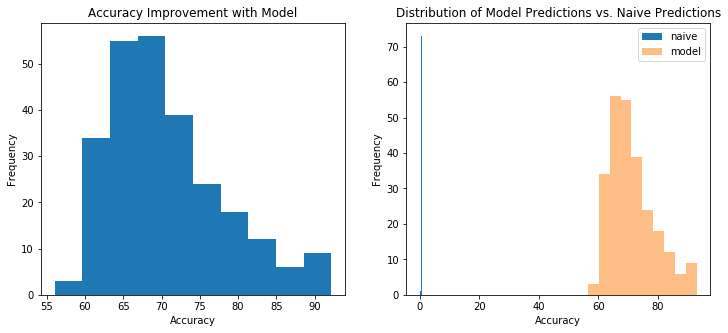

In [29]:
accuracy_diff_list = [accuracy_list[i] - naive_accuracy_list[i] for i in range(len(accuracy_list))]
pos_diff_list = [x for x in accuracy_diff_list if x > 0.]
improve_pct = round(len(pos_diff_list) / len(accuracy_diff_list) * 100., 1)
print(f"Percentage of pitcher models with accuracy improvement over naive prediction: {improve_pct}%")

fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(accuracy_diff_list, bins=10)
plt.title("Accuracy Improvement with Model")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")

plt.subplot(1, 2, 2)
plt.hist(naive_accuracy_list, label='naive')
plt.hist(accuracy_list, alpha=0.5, label='model')
plt.title("Distribution of Model Predictions vs. Naive Predictions")
plt.ylabel("Frequency")
plt.xlabel("Accuracy")
plt.legend(loc='best')
plt.show()